# Predictive Analytics Forcasting Project 

This is the MidTerm itteration of my project.



# -Problem/Signficance 




The quaility of the air that we breath is very important to our health. Poor Airqualitiy caused by polutants are a major concern for people because of the adverse health effects it can cause. That is why it is important to study the Quailty of our air. This project aims to forcast the AQI rating of the PM2.5 polutant on a daily basis from a single mesurement station in boston. This project focuses on PM2.5 for two reasons, First is that its one of the most dangerous polutaints beacuse of its ablity to enter deep into the lungs and even into the blood stream. The other reason is that the PM2.5 has the highest quality data.(most complete/lonngest time period withought long gaps missing)  Having an accurate forcast of AQI is important for companys, governments and individuals because it allows for preparadness. Some of the most vulnerable populations need to have extra time to prepare for High AQI rating. Populations who are houseless,poor and those with preexisting conditionns could benefit from the advanced warning. 

more basic info on pm 
https://www.epa.gov/pm-pollution/particulate-matter-pm-basics
https://www.epa.gov/pm-pollution/health-and-environmental-effects-particulate-matter-pm

# -Lit Review 

## - Packages ##

In [58]:
# Package imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.stats import boxcox


import missingno as msno

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, month_plot , quarter_plot , seasonal_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

%matplotlib inline


# - upload data 

In [7]:
# data from: https://aqicn.org/data-platform/register/
# this is the AQI rating for the day for particular polutants 

rawdata = pd.read_csv("/Users/averydavis/Desktop/Predictive_Analytics_Forecasting/Project/rawdata/boston-air-quality.csv")
# fill blanks with NaN
rawdata=rawdata.replace(r'^\s*$', np.nan, regex=True)

print("Shape of the data  "+ str(rawdata.shape))

##Check for missing data 
# uses a boolean statment to check for missing data 
print(rawdata.isnull().values.any())
rawdata


Shape of the data  (3355, 7)
True


,date,pm25,pm10,o3,no2,so2,co
0,2023/3/2,33,12,25,16,NaN,3
1,2023/3/3,30,10,30,12,NaN,2
2,2023/3/4,21,8,34,5,NaN,2
3,2023/3/5,17,9,29,12,NaN,3
4,2023/3/6,23,11,33,12,NaN,2
...,...,...,...,...,...,...,...
3350,2014/9/29,NaN,NaN,14,NaN,NaN,NaN
3351,2014/5/12,NaN,NaN,44,NaN,NaN,NaN
3352,2014/1/1,NaN,NaN,23,NaN,NaN,NaN
3353,2014/1/21,NaN,NaN,20,NaN,NaN,NaN


In [3]:
rawdata.info()
# must convert columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3355 non-null   object
 1    pm25   3334 non-null   object
 2    pm10   85 non-null     object
 3    o3     3331 non-null   object
 4    no2    2968 non-null   object
 5    so2    1320 non-null   object
 6    co     2948 non-null   object
dtypes: object(7)
memory usage: 183.6+ KB


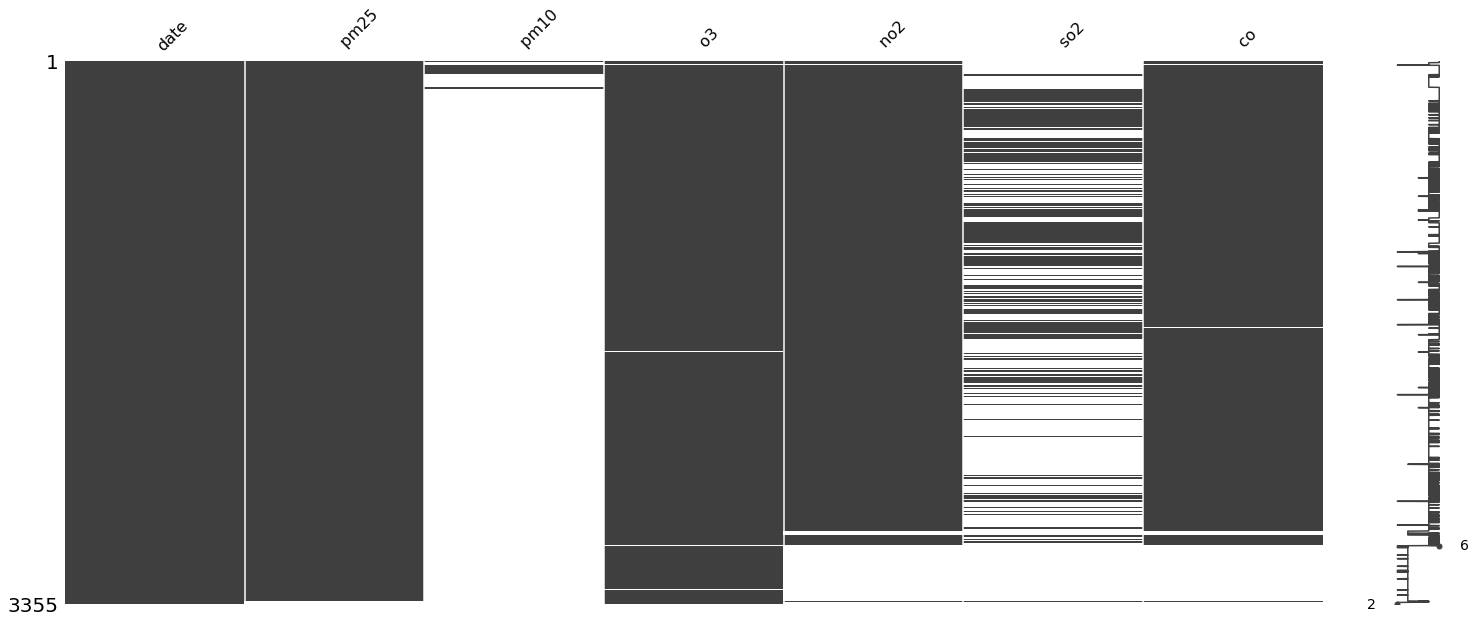

In [4]:
# vissualize the missing data 
msno.matrix(rawdata)
plt.show()

In [5]:
# maybe drop missing rows from the beginning because so many are missing from the start 
# maybe only try to predict pm25 & o3 becasue its the highest quality data



# need to gab other vairables 

# - Data enginering 

In this section we will be preparing the orginal raw data for the modeling process. There will be a few diffrent steps that will be used in oder to accomplish that task. First the data must be changed into the date time format so that it can be analyzed as a time series. Next there will need to be some features dropped, pm10 and so2 will be dropped due to a lack of observations. Those features are missinng too much data for imputation to work. 


In [22]:
s = pd.Series(rawdata.iloc[:,1])
s = s.astype(float)
s=s.dropna()
df=pd.DataFrame(s)
df.rename(columns={' pm25': 'pm25'}, inplace=True)

In [24]:
# Date time 
#create new date time index because the orignal one had some issues 
dti = pd.date_range("2014-02-24", periods=3334, freq="d")

#filp the order of data set to fit date time index 
df=df[::-1]

#set new index 
df.set_index(dti,inplace=True)

df["time"] = dti

df

/var/folders/hg/t4l1kwns6pd3rqm3kqkcqr4m0000gn/T/ipykernel_1048/2515388739.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = dti


,pm25,time
2014-02-24,33.0,2014-02-24
2014-02-25,30.0,2014-02-25
2014-02-26,21.0,2014-02-26
2014-02-27,17.0,2014-02-27
2014-02-28,23.0,2014-02-28
...,...,...
2023-04-07,38.0,2023-04-07
2023-04-08,50.0,2023-04-08
2023-04-09,29.0,2023-04-09
2023-04-10,15.0,2023-04-10


# -Data Visualization & Exploration

In [10]:
df.describe()

,pm25
count,3334.000000
mean,38.538392
std,13.225962
min,8.000000
25%,29.000000
50%,37.000000
75%,47.000000
max,104.000000


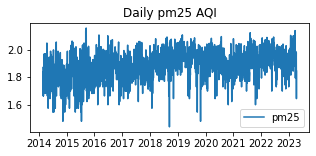

In [57]:
#line plot 
sns.lineplot(data=df)
plt.title("Daily pm25 AQI")
plt.rcParams["figure.figsize"] = (5,2)
plt.show()

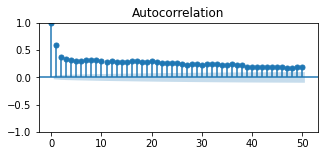

In [47]:
# ACF plot
fig1 =plot_acf(df['pm25'], lags=50)
plt.rcParams["figure.figsize"] = (5,2)
plt.show()

/Users/averydavis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/seasonal.py:338: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


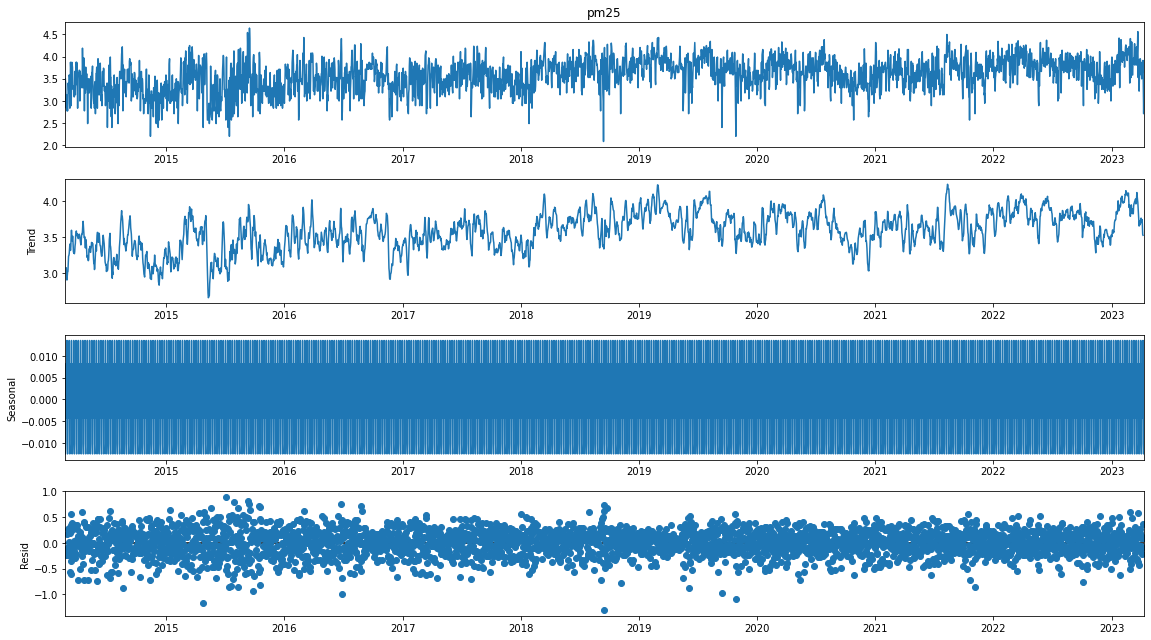

In [51]:
# seasonal decompostion 
decomp_viz = seasonal_decompose(df["pm25"],model="Additive")
fig = decomp_viz.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()


/Users/averydavis/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/averydavis/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/averydavis/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

Text(0, 0.5, 'PM2.5')

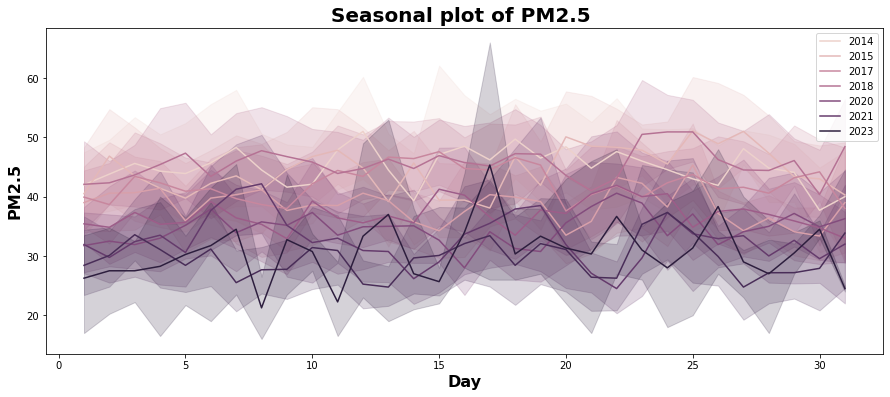

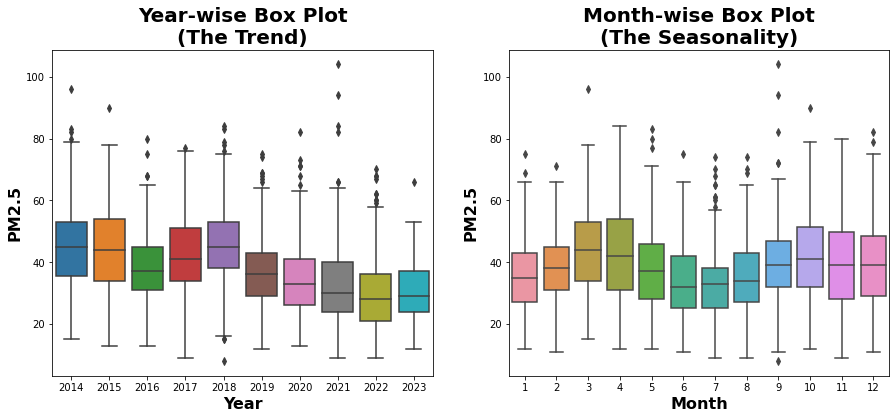

In [14]:
variable = ' pm25'
fig, ax = plt.subplots(figsize=(15, 6))


sns.lineplot(df.index.day, df[variable], hue=df.index.year)
ax.set_title('Seasonal plot of PM2.5 ', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('PM2.5', fontsize = 16, fontdict=dict(weight='bold'))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(df.index.year ,df[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('PM2.5', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(df.index.month, df[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('PM2.5', fontsize = 16, fontdict=dict(weight='bold'))

In [ ]:
# Kpss Test 
#The null hypothesis of the KPSS test is that the time series is stationary 
#The alternative hypothesis is that the time series is non-stationary

In [16]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
kpss_test(df)

Results of KPSS Test:
Test Statistic            4.271559
p-value                   0.010000
Lags Used                31.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/averydavis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [17]:
# our data is non stationary 

In [ ]:
# Test of Heteroscedasticity 

# H0 (Null Hypothesis): Homoscedasticity is present (the residuals are distributed with equal variance)
# HA (Alternative Hypothesis): Heteroscedasticity is present (the residuals are not distributed with equal variance)


In [63]:
from statsmodels.formula.api import ols
f =" pm25~time"
df_model = ols(formula=f, data=df).fit()

In [64]:
def test_model(col):
    s = []
    for i in col:
        a = [1,i]
        s.append(a)
    return (np.array(s))

pm_model = test_model(df['pm25'])


In [65]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(df_model.resid, pm_model)
print ('LM-test p-value')
print (bp_test[1])


LM-test p-value
0.029300958052375516


In [ ]:
# The data will need to be transformed because of the non-constant variance 

In [52]:
df_log = np.sqrt(df['pm25'])
dft = df
dft['pm25']= df_log
dft

/var/folders/hg/t4l1kwns6pd3rqm3kqkcqr4m0000gn/T/ipykernel_1048/2890080127.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['pm25']= df_log


,pm25,time
2014-02-24,1.869895,2014-02-24
2014-02-25,1.844234,2014-02-25
2014-02-26,1.744856,2014-02-26
2014-02-27,1.683215,2014-02-27
2014-02-28,1.770733,2014-02-28
...,...,...
2023-04-07,1.907246,2023-04-07
2023-04-08,1.977883,2023-04-08
2023-04-09,1.835019,2023-04-09
2023-04-10,1.645615,2023-04-10


/var/folders/hg/t4l1kwns6pd3rqm3kqkcqr4m0000gn/T/ipykernel_1048/930139566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pm25'], lam = boxcox(df['pm25'])


Lambda: 0.985158


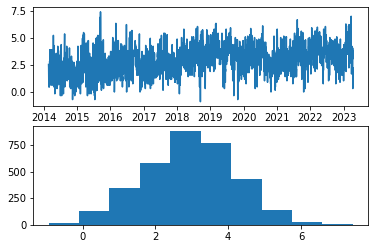

In [61]:
df['pm25'], lam = boxcox(df['pm25'])
print('Lambda: %f' % lam)
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(df['pm25'])
# histogram
plt.subplot(212)
plt.hist(df['pm25'])
plt.show()

In [ ]:
# box cox seems to work fairly well 

# - AR model 

In [67]:
mod = AutoReg(df['pm25'], 4, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 3334
Model:                     AutoReg(4)   Log Likelihood               -4626.062
Method:               Conditional MLE   S.D. of innovations              0.971
Date:                Fri, 31 Mar 2023   AIC                           9264.125
Time:                        11:36:58   BIC                           9300.789
Sample:                    02-28-2014   HQIC                          9277.243
                         - 04-11-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8587      0.054     15.996      0.000       0.753       0.964
pm25.L1        0.5785      0.017     33.587      0.000       0.545       0.612
pm25.L2       -0.0547      0.020     -2.748      0.0

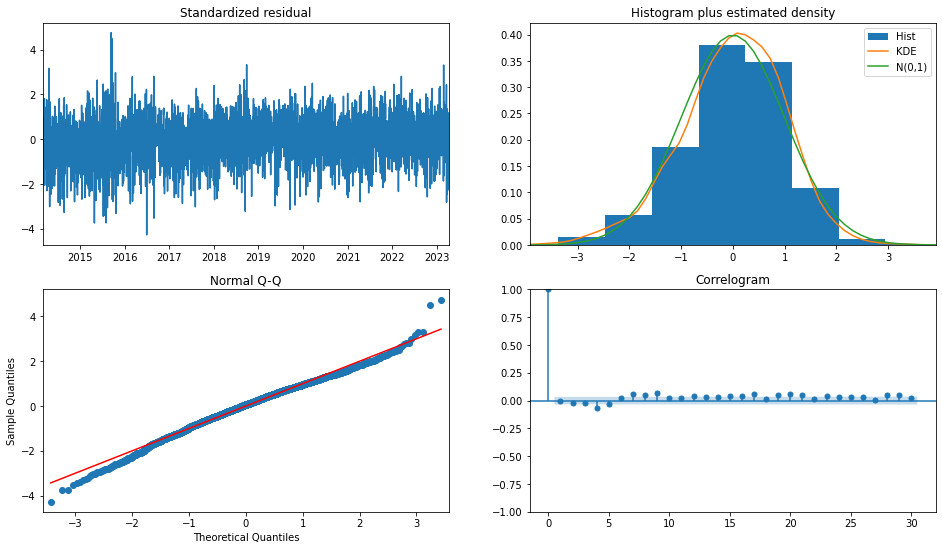

In [68]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


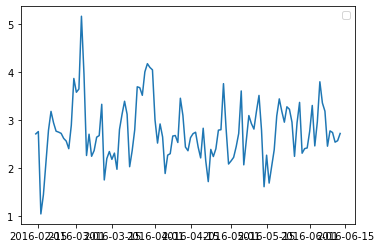

In [69]:
fig = res.plot_predict(720, 840)

# - ARIMA Model 

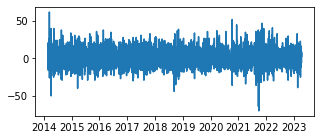

In [30]:
diff = df.diff()
plt.plot(diff)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   pm25   No. Observations:                 3334
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4691.401
Date:                Fri, 31 Mar 2023   AIC                           9394.802
Time:                        11:37:27   BIC                           9431.472
Sample:                    02-24-2014   HQIC                          9407.921
                         - 04-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3783      0.016    -23.151      0.000      -0.410      -0.346
ar.L2         -0.4165      0.017    -24.870      0.000      -0.449      -0.384
ar.L3         -0.3080      0.018    -17.463      0.0

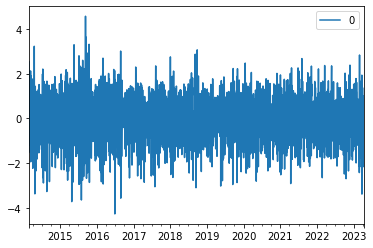

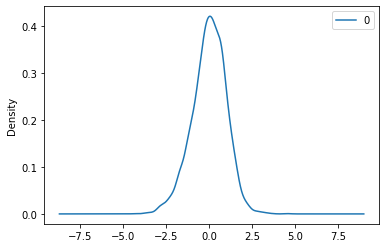

                 0
count  3334.000000
mean      0.000713
std       0.989627
min      -4.272483
25%      -0.596070
50%       0.053410
75%       0.671463
max       4.571209


In [70]:
# fit model
model = ARIMA(df['pm25'], order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())